In [19]:
from mpl_toolkits.basemap import Basemap
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
import matplotlib as mpl
from wrf import getvar, get_basemap, latlon_coords
from netCDF4 import Dataset
#from scipy import signal
from itertools import product
import matplotlib.colors as color
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [20]:
#open the prepared dataset (1981/12/15-2019/2/15)
data = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/case_study_ssts.nc', decode_cf=True)

In [33]:
data

<xarray.Dataset>
Dimensions:  (T: 2394, lat: 300, lon: 520)
Coordinates:
    zlev     float32 ...
  * lat      (lat) float32 -9.875 -9.625 -9.375 -9.125 ... 64.375 64.625 64.875
  * lon      (lon) float32 160.125 160.375 160.625 ... 289.375 289.625 289.875
  * T        (T) datetime64[ns] 1981-12-15T12:00:00 ... 2019-02-15
Data variables:
    sst      (T, lat, lon) float32 ...

In [21]:
#GoM bounds
lat_1 = 18.5
lat_2 = 30.5
lon_1 = -98+360
lon_2 = -82+360

In [58]:
#working on the linear plot ssts
#iterate helpers per year (days)
init_end = np.arange(0,2394,63)
fini_end = np.arange(63,2395,63)
#the number of years
num_years = np.unique(data.sst.coords['T'].dt.year).shape[0]-1
#colorbar for years iteration
colors = pl.cm.cividis_r(np.linspace(0,1,num_years))

In [59]:
init_end

array([   0,   63,  126,  189,  252,  315,  378,  441,  504,  567,  630,
        693,  756,  819,  882,  945, 1008, 1071, 1134, 1197, 1260, 1323,
       1386, 1449, 1512, 1575, 1638, 1701, 1764, 1827, 1890, 1953, 2016,
       2079, 2142, 2205, 2268, 2331])

In [60]:
fini_end

array([  63,  126,  189,  252,  315,  378,  441,  504,  567,  630,  693,
        756,  819,  882,  945, 1008, 1071, 1134, 1197, 1260, 1323, 1386,
       1449, 1512, 1575, 1638, 1701, 1764, 1827, 1890, 1953, 2016, 2079,
       2142, 2205, 2268, 2331, 2394])

In [61]:
#extract the GoM SSTs to compute area averaged SSTs for the basin
data_sliced = data.sst.sel(lat=slice(lat_1,lat_2),
                           lon=slice(lon_1,lon_2))
#grab that lats
latr = np.deg2rad(data_sliced.coords['lat'].values)
weights = np.cos(latr)
sst = np.ma.masked_array(data_sliced.values[:], 0.0)
sst_ave_zonal = np.ma.average(sst, axis=2)
sst_ave = np.ma.average(sst_ave_zonal, axis=1, weights=weights)
sst_ave = sst_ave.filled(0.0)

#if not doing area weighted
#ssta_nonarea = np.ma.average(data_sliced, axis=(1,2))
#ssta_nonarea = ssta_nonarea.filled(0.0)

In [62]:
#slice and take mean of 15-22 Jan
data_ssts = data.sst.sel(T=slice('2017-01-15T12:00:00','2017-01-22T12:00:00')).mean(dim='T',skipna=True)

In [63]:
#determine whether SST at each grid point was the record warmest for the 15-22 Jan period
#filter only the days of interest
find_max = data.sst[(data.sst.coords['T.month']==1)&(data.sst.coords['T.day']>=15)&(data.sst.coords['T.day']<=22)]
#take the mean of these days for each year
find_max = find_max.groupby('T.year').mean(dim='T', skipna=True)
#find the maximum mean annual value
find_max = find_max.max(dim='year', skipna=True)
records = np.zeros(find_max.shape) #array of zeros that will change to a 1 where record value identified
for i, j in product(range(len(find_max.values[:,0])),range(len(find_max.values[0,:]))):
    if np.isfinite(find_max.values[i,j]) and np.isfinite(data_ssts.values[i,j]):
        if find_max.values[i,j] == data_ssts.values[i,j] and data_ssts.values[i,j] != 0.:
            #assign a value of 1 if record
            records[i,j] = 1.

In [64]:
#compute anomalies

#daily anomalies
#climo = data.sst.groupby('T.dayofyear').mean('T', skipna=True)
#anom = data.sst.groupby('T.dayofyear') - climo
#data_anom = anom.sel(T=slice('2017-01-15T12:00:00','2017-01-22T12:00:00')).mean(dim='T',skipna=True)

#weekly anomalies
climo = data.sst.groupby('T.week').mean('T', skipna=True)
anom = data.sst.groupby('T.week') - climo
data_anom = anom.sel(T=slice('2017-01-15T12:00:00','2017-01-22T12:00:00')).mean(dim='T',skipna=True)

'''
#Not interested in anomalies here.
anom_detrend = np.zeros(anom.values.shape)
for i, j in product(range(len(anom.values[0,:,0])),range(len(anom.values[0,0,:]))):
    if np.all(np.isfinite(anom.values[:,i,j])):
        anom_detrend[:,i,j] = signal.detrend(anom.values[:,i,j])
anom_det = anom_detrend[np.where(pd.to_datetime(anom.coords['T'].values)==pd.to_datetime('2017-01-15T12:00:00'))[0][0]
                       :np.where(pd.to_datetime(anom.coords['T'].values)==pd.to_datetime('2017-01-22T12:00:00'))[0][0],:,:]
anom_det = np.nanmean(anom_det,axis=0)
'''

"\n#Not interested in anomalies here.\nanom_detrend = np.zeros(anom.values.shape)\nfor i, j in product(range(len(anom.values[0,:,0])),range(len(anom.values[0,0,:]))):\n    if np.all(np.isfinite(anom.values[:,i,j])):\n        anom_detrend[:,i,j] = signal.detrend(anom.values[:,i,j])\nanom_det = anom_detrend[np.where(pd.to_datetime(anom.coords['T'].values)==pd.to_datetime('2017-01-15T12:00:00'))[0][0]\n                       :np.where(pd.to_datetime(anom.coords['T'].values)==pd.to_datetime('2017-01-22T12:00:00'))[0][0],:,:]\nanom_det = np.nanmean(anom_det,axis=0)\n"

In [65]:
"""
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = color.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.cm.get_cmap('ocean_r')
new_cmap = truncate_colormap(cmap, 0.2, 1.0)
"""

import matplotlib as mpl

#cmap = ListedColormap(sns.cubehelix_palette(16, start=.5, rot=-.75).as_hex())

import matplotlib.colors as colorss

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colorss.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = plt.cm.get_cmap('Reds',20)
new_cmap = truncate_colormap(new_cmap, 0.1, 1.0)

In [66]:
#extract the wrf projection
ncfile2_wrf_d02 = Dataset('/glade/scratch/molina/wrf4km_ens_2/wrfout_d01_2017-01-15_09:00:00')
while True:
    dbz2_wrf_d02 = np.array([0])
    if len(dbz2_wrf_d02) == 1:
        try: 
            dbz2_wrf_d02 = getvar(ncfile2_wrf_d02, "dbz")
        except ValueError:
            continue
    if len(dbz2_wrf_d02) != 1:
        print('File Opened...')
        break
bm = get_basemap(dbz2_wrf_d02)

#adjust the wrf projection
llcrnrlon = bm.llcrnrlon
llcrnrlat = bm.llcrnrlat
urcrnrlon = bm.urcrnrlon-1.25
urcrnrlat = bm.urcrnrlat
bm = Basemap(projection='lcc', lat_0 = 10, lon_0 = -87, lat_1 = 40,
             llcrnrlon = llcrnrlon, llcrnrlat = llcrnrlat,
             urcrnrlat = urcrnrlat, urcrnrlon = urcrnrlon,
             resolution='l')

File Opened...


In [67]:
sst_ave.shape

(2394,)

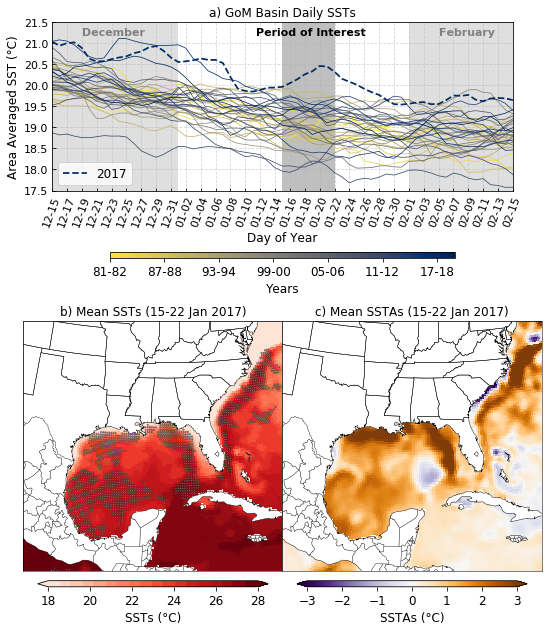

In [71]:
#########################################################################################
#########################################################################################
#########################################################################################


fig = plt.figure(figsize=(8.,8.5))

#fig.suptitle('Sea Surface Temperature (SST) Overview (1981-2019)', y=1.0, fontsize=12)

ax = fig.add_axes([0.1, 0.6675, 0.8, 0.275])


#########################################################################################

#iteration of line plot for ssts
for num, (i, j) in enumerate(zip(init_end, fini_end)):
    sst_to_plot = sst_ave[i:j]
    if num != 35:
        ax.plot(np.array(range(0,63)), sst_to_plot, color=colors[num], linewidth=0.75)
    if num == 35:
        #make 2017 different
        cs = ax.plot(np.array(range(0,63)), sst_to_plot, color=colors[num], linestyle='--', linewidth=1.75)
        custom_line = [Line2D([0], [0], color=colors[num], linestyle='--', linewidth=1.75)]
    
ax.margins(y=0, tight=None)
ax.set_xlim(0, 62)

plt.rcParams['axes.xmargin'] = 0

ax.set_xticks(np.arange(0,63,2))
ax.set_xticklabels(pd.to_datetime(data_sliced.coords['T'].values[:]).strftime('%m-%d')[0:63:2], fontsize=11, rotation=70, ha='right', rotation_mode='anchor')
ax.set_yticks([17.5,18.0,18.5,19.0,19.5,20.0,20.5,21.0,21.5])
ax.set_yticklabels(['17.5','18.0','18.5','19.0','19.5','20.0','20.5','21.0','21.5'], fontsize=11)

ax.grid(True, linestyle='--', alpha=0.5)

#background colors
ax.axvspan(0, 17, color='silver', alpha=0.5, lw=0)
ax.axvspan(48, 63, color='silver', alpha=0.5, lw=0)
ax.axvspan(31, 38, color='grey', alpha=0.5, lw=0)
#background text
ax.text(4.,21.2,'December',color='grey',fontsize=11,fontweight='bold')
ax.text(52.,21.2,'February',color='grey',fontsize=11,fontweight='bold')
ax.text(27.5,21.2,'Period of Interest',color='k',fontsize=11,fontweight='bold')

ax.tick_params(axis='both', which='both', direction='in')

ax.set_xlabel('Day of Year', fontsize=12)

ax.set_title('a) GoM Basin Daily SSTs', fontsize=12)

a = u"\u00b0"
ax.set_ylabel('Area Averaged SST ('+a+'C)', fontsize=12)

ax.legend([custom_line[0]],
          [u"2017"],
          loc="lower left",
          fancybox=True, fontsize=12)


#########################################################################################

#colorbar for line plot years
cbar_ax = fig.add_axes([0.2, 0.5575, 0.6, 0.01])

cmap = mpl.cm.cividis_r
norm = mpl.colors.Normalize(vmin=0, vmax=num_years)

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',
                                ticks=np.array([0,6,12,18,24,30,36]))

cb1.set_label('Years', fontsize=12)

cb1.ax.set_xticklabels(['81-82','87-88',
                        '93-94',
                        '99-00','05-06',
                        '11-12',
                        '17-18'])

cb1.ax.tick_params(labelsize=12)

#########################################################################################
#########################################################################################
#########################################################################################


ax2 = fig.add_axes([0.05, 0.0, 0.45, 0.5])

ax2.set_title('b) Mean SSTs (15-22 Jan 2017)', fontsize=12)

lons = data.coords['lon'].values
lats = data.coords['lat'].values

lons, lats = np.meshgrid(lons,lats)
x, y = bm(lons, lats)

ax2.pcolormesh(x, y, data_ssts.values, cmap=new_cmap, vmin=18, vmax=28)

ax2.scatter(x, y, records*1.5, facecolors='w', edgecolors='k', linewidth=0.4, zorder=10)

bm.drawmapboundary(linewidth=0.5, fill_color='none', zorder=4)
bm.fillcontinents(color='w', lake_color='w', zorder=3)
bm.drawcoastlines(linewidth=0.45, zorder=4)
bm.drawcountries(linewidth=0.4, zorder=4)
bm.drawstates(linewidth=0.45, zorder=4)

#bm.drawmeridians(np.arange(int(-95),int(-79),5), labels=[0,0,0,1], linewidth=0.0, fontsize=11)
#bm.drawparallels(np.arange(int(20),int(50),5), labels=[1,0,0,0], linewidth=0.0, fontsize=11)


#########################################################################################

#colorbar for ssts
cbar_ax = fig.add_axes([0.075, 0.02, 0.4, 0.01])

cmap = new_cmap
norm = mpl.colors.Normalize(vmin=18, vmax=28)

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',
                                ticks=np.array([18,20,22,24,26,28,30]),
                                extend='both')

cb1.set_label('SSTs ('+a+'C)', fontsize=12)

cb1.ax.tick_params(labelsize=12)

#########################################################################################
#########################################################################################
#########################################################################################


ax3 = fig.add_axes([0.5, 0.0, 0.45, 0.5])

ax3.set_title('c) Mean SSTAs (15-22 Jan 2017)', fontsize=12)

lons = data.coords['lon'].values
lats = data.coords['lat'].values

lons, lats = np.meshgrid(lons,lats)
x, y = bm(lons, lats)

#ax3.pcolormesh(x, y, data_anom.values, cmap=plt.cm.get_cmap('seismic'), vmin=-3, vmax=3)
ax3.pcolormesh(x, y, data_anom.values, cmap=plt.cm.get_cmap('PuOr_r'), vmin=-3, vmax=3)

bm.drawmapboundary(linewidth=0.5, fill_color='none', zorder=4)
bm.fillcontinents(color='w', lake_color='w', zorder=3)
bm.drawcoastlines(linewidth=0.45, zorder=4)
bm.drawcountries(linewidth=0.4, zorder=4)
bm.drawstates(linewidth=0.45, zorder=4)

#bm.drawmeridians(np.arange(int(-95),int(-79),5), labels=[0,0,0,1], linewidth=0.0, fontsize=11)


#########################################################################################

#colorbar for sstas
cbar_ax = fig.add_axes([0.525, 0.02, 0.4, 0.01])

#cmap = mpl.cm.seismic
cmap = mpl.cm.PuOr_r

norm = mpl.colors.Normalize(vmin=-3, vmax=3)

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',
                                ticks=np.array([-3,-2,-1,0,1,2,3]),
                                extend='both')

cb1.set_label('SSTAs ('+a+'C)', fontsize=12)

cb1.ax.tick_params(labelsize=12)

    
#########################################################################################
#########################################################################################
#########################################################################################


plt.savefig('/glade/work/molina/DATA/temp_figs/mwr2019_fig5.png', bbox_inches='tight', dpi=1200)
plt.savefig('/glade/work/molina/DATA/temp_figs/mwr2019_fig5_lowdpi.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()


#########################################################################################
#########################################################################################
#########################################################################################